# Week 5: GANs

The purpose of this notebook is to use a Generative Neural Network architecture to generate images that appear similar in style to paintings by famous French impressionist painter Claude Monet. The project is for a Kaggle competition titled "I'm Something of a Painter Myself". The data, provided by Kaggle, consists of 256x256 pixel RGB images. There are 300 Monet paintings and 7038 real photographs. Using these we trained GANs to learn features of Monet's distinct style.

In this notebook, two separate attempts using two different types of GAN were made towards this goal. The first involved a DCGAN with an attempt to generate Monet style pictures from random latent vectors. The second attempt uses a CycleGAN to "Monet-ify" the photos in our dataset.  

## Import

First we import the data and set some hyperparameters that we will need throughout the notebook.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

#strategy = tf.distribute.get_strategy()
#AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow version {tf.__version__}')

AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = [256, 256]
IMAGE_SHAPE = (256, 256, 3)
BATCH_SIZE = 4
OUTPUT_CHANNELS = 3

monet_dir = 'gan-getting-started/monet_tfrec'
photo_dir = 'gan-getting-started/photo_tfrec'

monet_files = tf.io.gfile.glob(os.path.join(monet_dir, '*.tfrec'))
photo_files = tf.io.gfile.glob(os.path.join(photo_dir, '*.tfrec'))

print('Monet TFRecord File Count:', len(monet_files))
print('Photo TFRecord Files Count:', len(photo_files))

2025-06-14 13:26:06.023023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749875166.030548  334027 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749875166.032800  334027 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749875166.039257  334027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749875166.039267  334027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749875166.039268  334027 computation_placer.cc:177] computation placer alr

Tensorflow version 2.19.0
Monet TFRecord File Count: 5
Photo TFRecord Files Count: 20


## Data Inspection and Exploratory Analysis

Next, we investigate the files structure. What features about the image are included in the Kaggle dataset? It appears each photo has 3 features included, the target, image name, and the image data.

In [2]:
def feature_names(tfrecord_file):
    dataset = tf.data.TFRecordDataset(tfrecord_file, num_parallel_reads=AUTOTUNE)
    for record in dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(record.numpy())
        feature_names = list(example.features.feature.keys())
    return feature_names

print("Monet feature Names:", feature_names(monet_files[0]))
print("Photo feature Names:", feature_names(photo_files[0]))

I0000 00:00:1749875167.405182  334027 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Monet feature Names: ['target', 'image_name', 'image']
Photo feature Names: ['target', 'image_name', 'image']


Prepare a function to return the image_data.

In [3]:
def read_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)

    # Decode image
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0

    return image


Import image data.

In [4]:
def load_dataset(filenames):
    return (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    )

monet_ds = load_dataset(monet_files).shuffle(2048).batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = load_dataset(photo_files).shuffle(2048).batch(BATCH_SIZE).prefetch(AUTOTUNE)

Just to be safe, we verify the first image meets the expected 256x256 RGB format.

In [5]:
for batch in monet_ds.take(1):
    print(f'Image dimensions: {batch.shape[1:]}')

Image dimensions: (256, 256, 3)


Next, let's look at some visualizations of our data.

First, we check the size of our two targets. It appears that there are far more (7,038) photos than Monet paintings (300). The size of the Monet dataset seems rather small which could pose a challenge for our networks to learn essential features.

Number of images in Monet dataset: 300
Number of images in Photo dataset: 7038


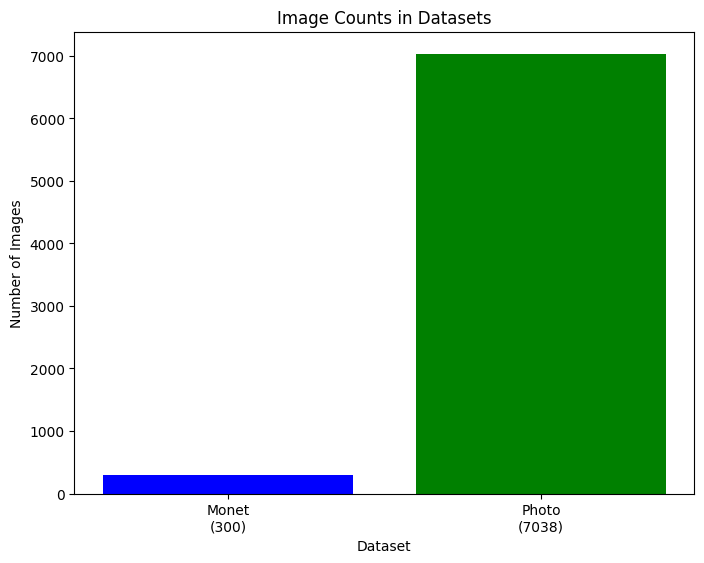

In [6]:
def count_images_in_dataset(dataset):
    count = 0
    for batch in dataset:
        # Each batch is a tensor of shape [batch_size, height, width, channels]
        count += batch.shape[0]
    return count

num_monet = count_images_in_dataset(monet_ds)
num_photo = count_images_in_dataset(photo_ds)

print("Number of images in Monet dataset:", num_monet)
print("Number of images in Photo dataset:", num_photo)

dataset_names = [f'Monet\n({num_monet})', f'Photo\n({num_photo})']
counts = [num_monet, num_photo]

plt.figure(figsize=(8, 6))
plt.bar(dataset_names, counts, color=['blue', 'green'])
plt.xlabel("Dataset")
plt.ylabel("Number of Images")
plt.title("Image Counts in Datasets")
plt.show()


We visualized the first batch of Monet images and photos.

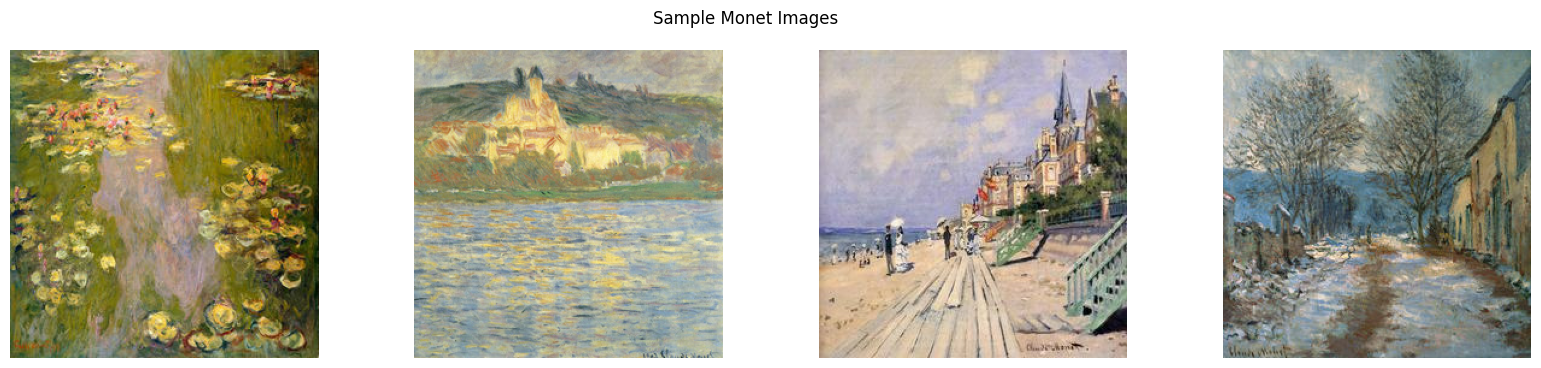

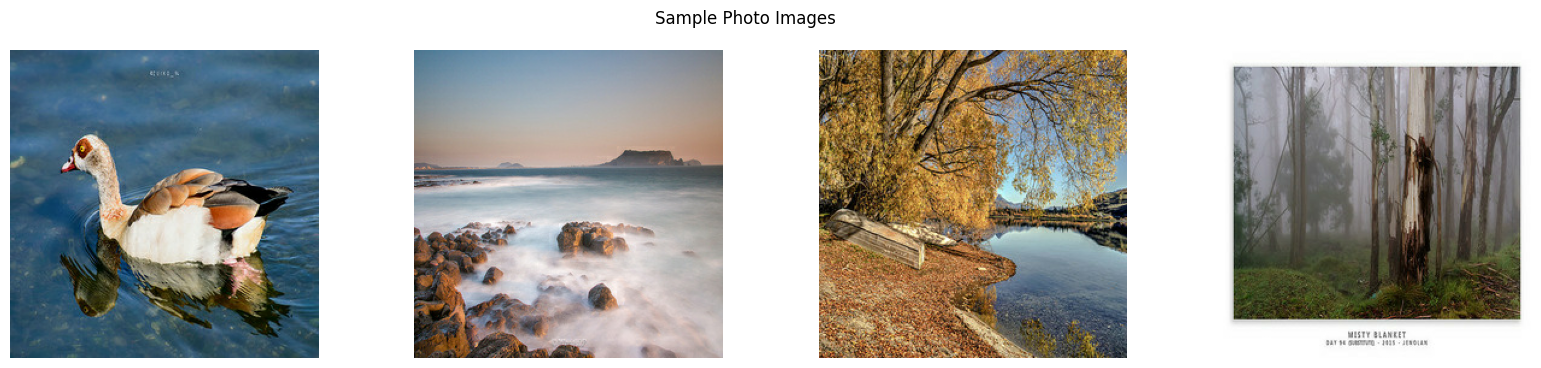

In [7]:
def show_sample(dataset, title):
    plt.figure(figsize=(20, 4))
    for i, image in enumerate(dataset.take(1)):
        for j in range(BATCH_SIZE):
            plt.subplot(1, BATCH_SIZE, j + 1)
            plt.imshow((image[j] + 1) / 2.0)  # Convert back to [0, 1]
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_sample(monet_ds, "Sample Monet Images")
show_sample(photo_ds, "Sample Photo Images")

Visualize the RGB Channels for each dataset. From this analysis it appears that the Monet paintings tend use deeper more intense colors. This tendency appears most prominently in the Green channel, but exists across all three channels.

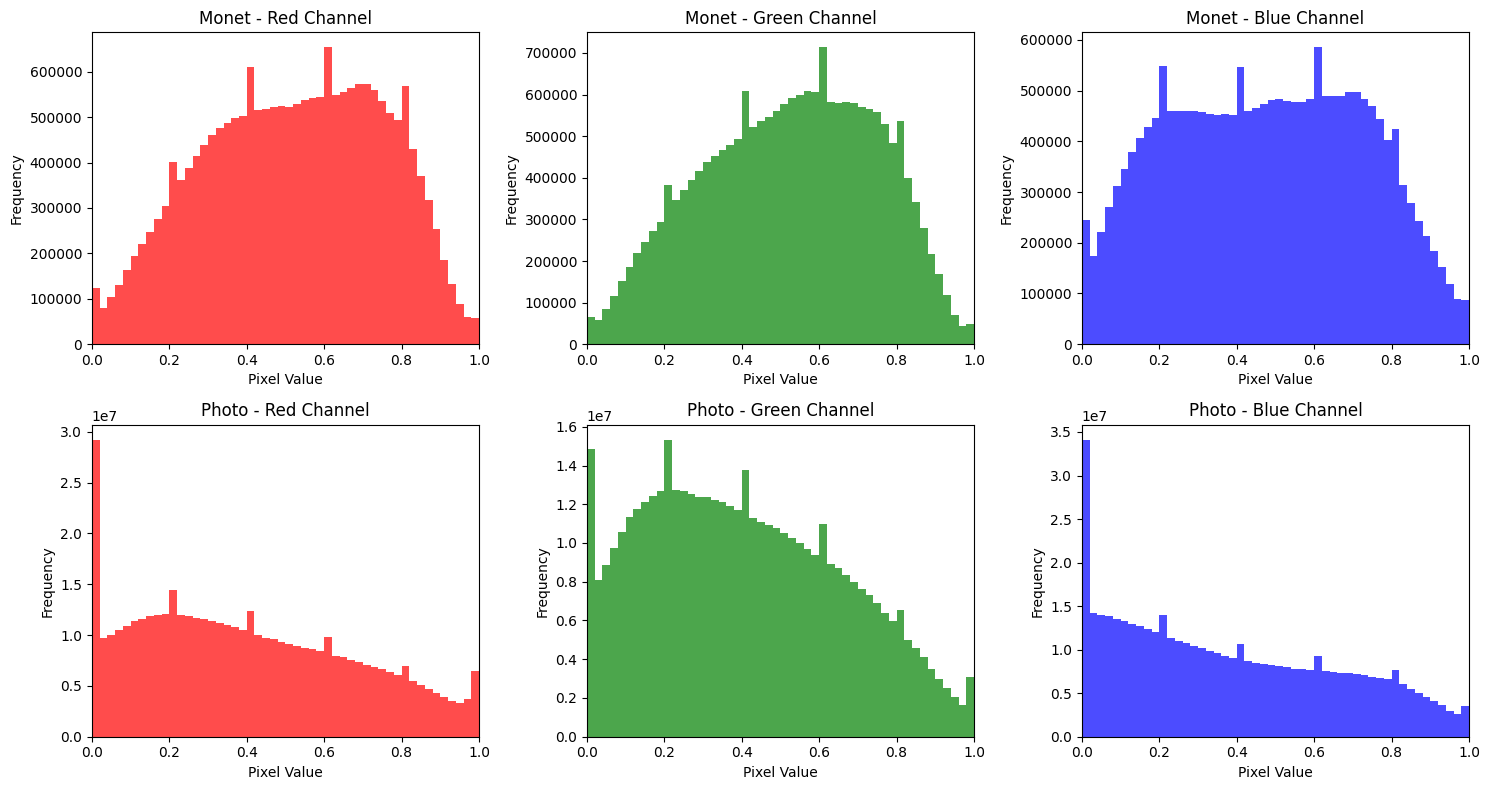

In [8]:
def all_images_to_array(dataset):
    images = []
    for batch in dataset:
        for img in batch:
            images.append(img.numpy())
    return np.stack(images)

# Collect all images from each dataset
monet_all = all_images_to_array(monet_ds)
photo_all = all_images_to_array(photo_ds)

# Rescale from [-1, 1] to [0, 1]
monet_all = (monet_all + 1) / 2.0
photo_all = (photo_all + 1) / 2.0

# Plot RGB channel distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, (samples, label) in enumerate(zip([monet_all, photo_all], ['Monet', 'Photo'])):
    for c, color in enumerate(['Red', 'Green', 'Blue']):
        axes[i, c].hist(samples[..., c].flatten(), bins=50, color=color.lower(), alpha=0.7)
        axes[i, c].set_title(f'{label} - {color} Channel')
        axes[i, c].set_xlim(0, 1)
        axes[i, c].set_xlabel('Pixel Value')
        axes[i, c].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

## Model DCGAN (attempt 1)

The first GAN architecture we employed was a DCGAN. Like all GANs and like the term 'adversarial' implies, the DCGAN consists of two competing actors, a Discriminator that tries to classify real and fake images (in this case Monet and not-Monet), and a Generator that attempts to create images that can fool the discriminator. Each one is constantly learning by updating its parameters to improve its performance at its task. 

The DCGAN architecture builds on the fundamental adversarial process of GANs, where a generator and discriminator engage in a competitive learning process to produce increasingly realistic images. The generator starts from a latent vector, progressively transforming it into a high-resolution 256×256 image through a sequence of transposed convolutions, each followed by batch normalization and LeakyReLU activation. This layered approach ensures both fine-grained detail retention and controlled gradient flow, preventing instability during training. The final activation function, tanh, scales the generated output to match the range of real images.

The discriminator, in contrast, is a fully convolutional classifier designed to distinguish authentic Monet paintings from synthetic ones. Using a series of convolutional layers, dropout, and LeakyReLU, it reduces the image spatial dimensions while capturing essential structural patterns. Rather than applying a sigmoid activation at the output, it directly returns logits, allowing for binary cross-entropy loss with soft labels, which improves generalization and adversarial robustness.

Training is guided by an adversarial loss function where the generator strives to fool the discriminator into misclassifying its outputs as real paintings, while the discriminator continually refines its ability to detect fakes. Tuning the Adam optimizer was a very time-consuming process, setting learning rates of generator and discriminator at the same level led to a quick mode collapse where the discriminator dominated the generator leading to the generator failing to produce meaningful outputs that were visually distinguishable from purely random noise. The model was allowed to train for 1000 epochs, producing some sample images every 10 epochs to verify its progress.

While there are examples of successful DCGAN Monet generators, after days of tinkering with hyperparameters and architecture, many iterations of DCGAN produced incredibly striking images, but unfortunately none of them resembled Monet paintings to the satisfaction of the authors. As such, the DCGAN method was abandoned, but it is included here because several days of work did go into this pursuit.

Because the Monet dataset is fairly small (300), we applied augmentation to the data. Each image was flipped, mirrored, cropped randomly, and had gaussian noise added, and each of these new images was added to our dataset. This gave our training dataset for the DCGAN a total of 1500 images.

In [9]:
def mirror(image):
    # mirror the image (flip left to right)
    return tf.image.flip_left_right(image)

def flip(image):
    # flip image upside down
    return tf.image.flip_up_down(image)

def crop(image):
    # enlarge and randomly crop image back to original size
    image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[256, 256, 3])
    return image

def add_gaussian_noise(image, std=0.05):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=std, dtype=tf.float32)
    return tf.clip_by_value(image + noise, 0.0, 1.0)

'''def augment_dataset(dataset):
    dataset = dataset.concatenate(dataset.map(mirror, num_parallel_calls=AUTOTUNE))
    dataset = dataset.concatenate(dataset.map(flip, num_parallel_calls=AUTOTUNE))
    dataset = dataset.concatenate(dataset.map(crop, num_parallel_calls=AUTOTUNE))
    dataset = dataset.concatenate(dataset.map(add_gaussian_noise, num_parallel_calls=AUTOTUNE))
    dataset = dataset.shuffle(7500, reshuffle_each_iteration=True)
    return dataset
'''
def augment_dataset(dataset):
    original = dataset
    mirrored = dataset.map(mirror, num_parallel_calls=AUTOTUNE)
    flipped = dataset.map(flip, num_parallel_calls=AUTOTUNE)
    cropped = dataset.map(crop, num_parallel_calls=AUTOTUNE)
    noised = dataset.map(add_gaussian_noise, num_parallel_calls=AUTOTUNE)

    dataset = original.concatenate(mirrored)
    dataset = dataset.concatenate(flipped)
    dataset = dataset.concatenate(cropped)
    dataset = dataset.concatenate(noised)

    #dataset = dataset.shuffle(7500, reshuffle_each_iteration=True)
    return dataset


num_monet = count_images_in_dataset(monet_ds)
print("Number of images in Monet dataset:", num_monet)

monet_ds = load_dataset(monet_files).shuffle(8000, reshuffle_each_iteration=True)
monet_ds = augment_dataset(monet_ds)
#monet_ds = monet_ds.shuffle(8000, reshuffle_each_iteration=True)
monet_ds = monet_ds.batch(BATCH_SIZE).repeat(2).prefetch(AUTOTUNE)

num_monet = count_images_in_dataset(monet_ds)
print("Number of images in Monet dataset:", num_monet)


Number of images in Monet dataset: 300
Number of images in Monet dataset: 3000


Then we prepare the generator and discriminator functions.

In [10]:
LATENT_DIM = 128

def build_generator(negative_slope=0.2):
    model = tf.keras.Sequential([
        layers.Input(shape=(LATENT_DIM,)),
        layers.Dense(8*8*LATENT_DIM, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=negative_slope),

        layers.Reshape((8, 8, LATENT_DIM)),

        #layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same', use_bias=False), # (8, 8, 512)
        #layers.BatchNormalization(),
        #layers.LeakyReLU(negative_slope=negative_slope),

        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False), # (16, 16, 256)
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=negative_slope),

        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False), # (32, 32, 128)
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=negative_slope),

        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False), # (64, 64, 64)
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=negative_slope),

        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', use_bias=False),  # (128, 128, 32)
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=negative_slope),

        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', use_bias=False, activation='tanh') # (256, 256, 3)
    ])
    return model

In [11]:
def build_discriminator(negative_slope=0.2, dropout_rate=0.3):
    model = tf.keras.Sequential([
        layers.Input(shape=IMAGE_SHAPE),
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same'), # (128, 128, 64)
        layers.LeakyReLU(negative_slope=negative_slope),
        layers.Dropout(dropout_rate),

        layers.Conv2D(128, kernel_size=4, strides=2, padding='same'), # (64, 64, 128)
        layers.LeakyReLU(negative_slope=negative_slope),
        layers.Dropout(dropout_rate),

        layers.Conv2D(256, kernel_size=4, strides=2, padding='same'), # (32, 32, 256)
        layers.LeakyReLU(negative_slope=negative_slope),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(1)  # No activation — using logits
    ])
    return model

Our DCGAN class, with a base class of tf.keras.Model.

In [12]:
class DCGAN(tf.keras.Model):
    def __init__(self, generator=build_generator(), discriminator=build_discriminator(), image_shape=(256, 256, 3), latent_dim=LATENT_DIM):
        super().__init__()
        self.image_shape = image_shape
        self.latent_dim = latent_dim
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def compile(self, d_optimizer=tf.keras.optimizers.Adam(1e-4), g_optimizer=tf.keras.optimizers.Adam(1e-4)):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def generator_loss(self, fake_output):
        smooth_real_labels = 0.9
        return self.cross_entropy(tf.ones_like(fake_output) * smooth_real_labels, fake_output)

    def discriminator_loss(self, real_output, fake_output):
        real_labels = tf.random.uniform(tf.shape(real_output), minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(tf.shape(fake_output), minval=0.0, maxval=0.1)

        real_loss = self.cross_entropy(tf.ones_like(real_output) * real_labels, real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output) + fake_labels, fake_output)
        return real_loss + fake_loss

    @tf.function
    def train_step(self, real_images, update_discriminator=True):
        noise = tf.random.normal([tf.shape(real_images)[0], self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            noisy_real_images = real_images + tf.random.normal(shape=tf.shape(real_images), mean=0.0, stddev=0.05)
            real_output = self.discriminator(noisy_real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        if update_discriminator:
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"gen_loss": gen_loss, "disc_loss": disc_loss}

We define a callback that will generate test images every 10 epochs.

In [13]:
def generate_and_save_images(generator, epoch, test_input, out_dir='generated_images', display=False):
    predictions = generator(test_input, training=False)
    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2.0)
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    if display:
        plt.show()
    else:
        os.makedirs(out_dir, exist_ok=True)
        path = os.path.join(out_dir, f'image_at_epoch_{epoch:04d}.png')
        plt.savefig(path)
    plt.close()

class ImageGenerationCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, test_input, out_dir='generated_images', interval=10):
        super().__init__()
        self.generator = model.generator
        self.input = test_input
        self.out_dir = out_dir
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            generate_and_save_images(self.generator, epoch + 1, self.input, out_dir=self.out_dir)


Finally, we build, compile, and train the model.

In [ ]:
generator = build_generator()
discriminator = build_discriminator()

dcgan = DCGAN(generator=generator, discriminator=discriminator, image_shape=(256, 256, 3), latent_dim=LATENT_DIM)

dcgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
)

In [15]:
EPOCHS = 500

latent_input = tf.random.uniform([16, LATENT_DIM])
imgen_callback = ImageGenerationCallback(model=dcgan, test_input=latent_input, out_dir='generated_images', interval=5)

history = dcgan.fit(
    tf.data.Dataset.zip((monet_ds)),
    epochs=EPOCHS,
    callbacks=[imgen_callback]
)

Epoch 1/500


I0000 00:00:1749875193.481214  334201 service.cc:152] XLA service 0x7f19c4002100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749875193.481248  334201 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
I0000 00:00:1749875193.767110  334201 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-06-14 13:26:38.730934: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng57{k2=8,k13=1,k14=1,k18=1,k23=0} for conv %cudnn-conv-bw-filter.15 = (f32[32,3,4,4]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,256,256]{3,2,1,0} %bitcast.27500, f32[4,32,128,128]{3,2,1,0} %bitcast.27502), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="StatefulPartitionedCall/gradient_tape/sequential_2_1/conv2d_transpose_9_1/conv_transpose/Conv2DBackpropFilter" source_file="/home/coach

      2/Unknown 10s 58ms/step - disc_loss: 1.3802 - gen_loss: 0.7118

I0000 00:00:1749875202.161785  334201 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - disc_loss: 2.4685 - gen_loss: 0.3655
Epoch 2/500
 11/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - disc_loss: 2.5218 - gen_loss: 0.3773

/home/coach/miniconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - disc_loss: 2.5235 - gen_loss: 0.3813
Epoch 3/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - disc_loss: 2.5749 - gen_loss: 0.4866
Epoch 4/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - disc_loss: 2.0931 - gen_loss: 0.6954
Epoch 5/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - disc_loss: 2.0489 - gen_loss: 0.6883
Epoch 6/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - disc_loss: 2.0627 - gen_loss: 0.6432
Epoch 7/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - disc_loss: 1.9421 - gen_loss: 0.6049
Epoch 8/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - disc_loss: 1.7494 - gen_loss: 0.5779
Epoch 9/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - disc_loss: 1.7550 - gen_loss: 0.5699
Epoch 10/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - disc_loss: 1.6241 - gen_loss: 0.5877
Epoch 11/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - disc_loss: 1.5982 - gen_loss: 0.6049
Epoch 12/500
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - disc_loss: 1.6049 - g

### Results and analysis

As we see in our plot of Generator and Discriminator loss, with the learning rates handicapping the discriminator, the generator was able to start strong, with the discriminator playing catch-up. The plot reveals an interesting dynamic between the two networks. Initially, the generator loss starts around 0.75 and remains relatively stable, while the discriminator loss drops sharply from 2.25 to approximately 1.25 before stabilizing. This suggests that the generator quickly established a strong ability to produce outputs that fooled the discriminator, leading to a relatively balanced adversarial process. With this balance the discriminator did not entirely overpower the generator, possibly allowing some instability in how the generator utilized latent space inputs.

After training, we examined some of the images generated at different epochs. While the generator is producing some very interesting images there are two obvious visual issues. The first is that, while Monet's impressionist style is abstract, they still generally contain visually identifiable objects, people, and landscapes. Our fake Monet images appear purely abstract with no identifiable objects. This is likely because that it's capturing stylistic elements of Monet but is not capable of understanding the representations contained in the images.

The second issue is that from at least epoch 50, the images generated appear identical regardless of the latent input given to our generator. In other words, it seems to just be generating what it "thinks" is a Monet painting without any regard for the input. We attempted to resolve this by systematically adjusting hyperparameters such as learning rates, beta values, and latent dimension sizes. Additionally, we experimented with different architectural changes, including modifying the generator’s initial dense layer and adjusting batch normalization settings. However, despite extensive tuning, the issue persisted. Each attempt led to minimal or no improvement, indicating a deeper structural problem in the training process. Recognizing that incremental changes were unlikely to resolve the fundamental issue, we decided to take a step back and rebuild the model from scratch. This is where our experiment into DCGAN ended and our journey into CycleGAN began.


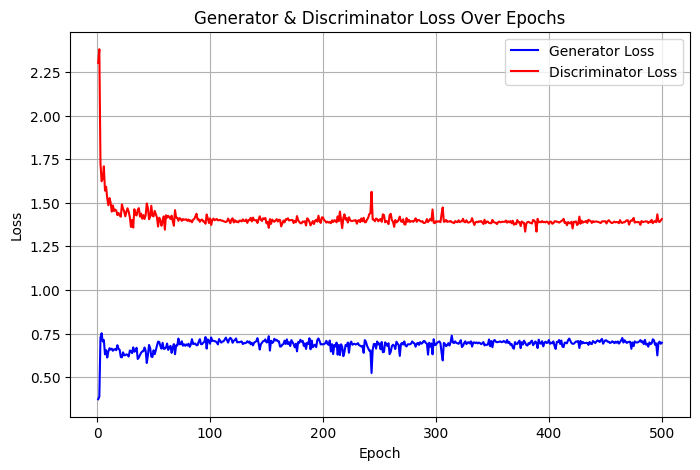

In [16]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """Plots generator and discriminator loss by epoch."""
    epochs = range(1, len(history.history['gen_loss']) + 1)

    plt.figure(figsize=(8, 5))
    
    # Plot generator loss
    plt.plot(epochs, history.history['gen_loss'], label="Generator Loss", color='blue')
    
    # Plot discriminator loss
    plt.plot(epochs, history.history['disc_loss'], label="Discriminator Loss", color='red')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator & Discriminator Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call function after training
plot_loss(history)

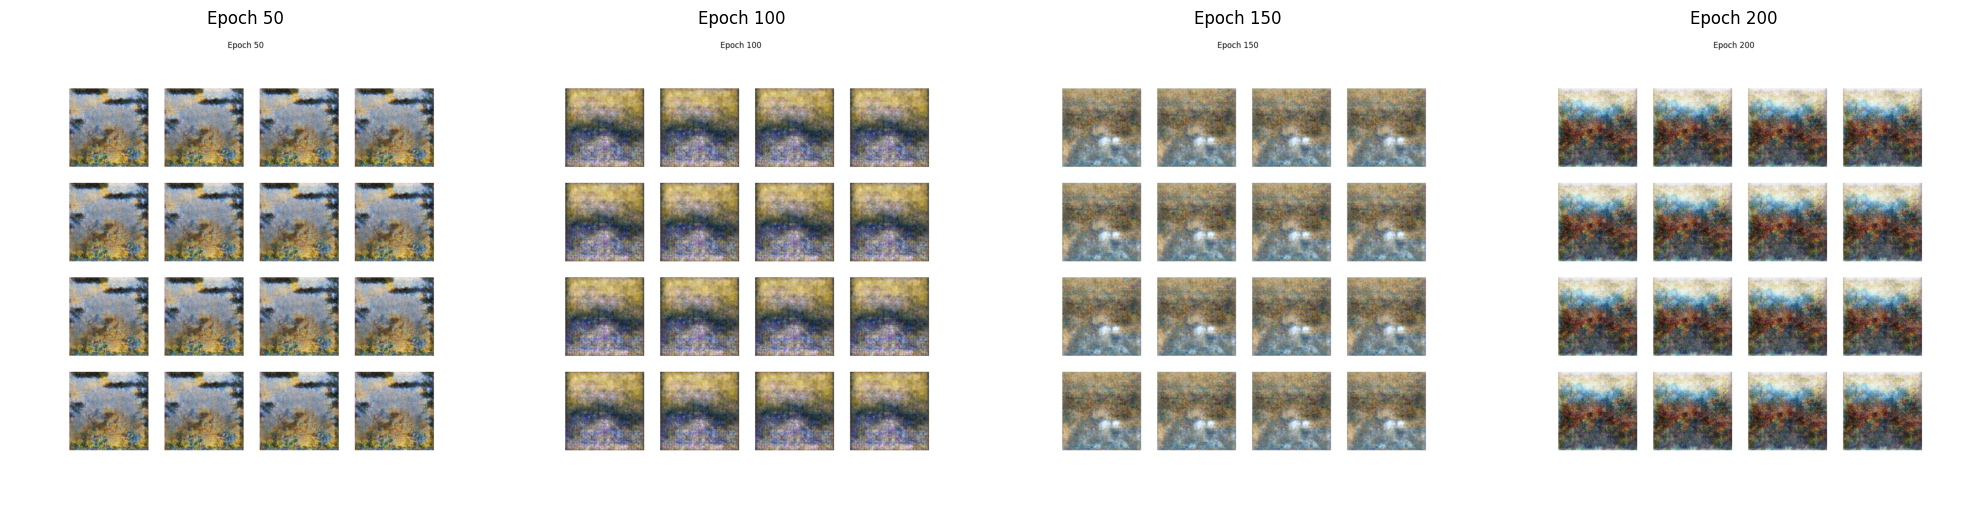

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_images_from_epochs(out_dir, step=50, max_epoch=1000):
    images = []
    for epoch in range(0, max_epoch + 1, step):
        img = f'image_at_epoch_{epoch:04d}.png'
        img_path = os.path.join(out_dir, img)
        if os.path.exists(img_path):
            images.append((epoch, img_path))
    n = len(images)
    if n == 0:
        print("No images found at 20-epoch intervals.")
        return
    cols = 4
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 5))
    for i, (epoch, img_path) in enumerate(images):
        img = Image.open(img_path)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_from_epochs('generated_images', max_epoch=EPOCHS)


## Model 2: CycleGAN

A Cycle-Consistent Generative Adversarial Network (CycleGAN) architecture is designed to perform image-to-image translation. CycleGAN learns to map between two visual styles, in our case Monet paintings and real photographs. Like all GANs, CycleGANs consist of generators and discriminators in competition with each other. Unlike DCGAN however, CycleGAN has two of each. In our case, one generator learns to translate images from Monet style paintings to real photos and the other from photos to Monet. The "Cycle-Consistent" is the idea that an image translated from one domain and then back to its original domain should be similar to the original image. That is to say a Monet painting converted to a photograph and then back to a Monet image should be visually consistent with the original Monet painting. This allows the CycleGAN model to learn meaningful and reversible tranformations.

The generators follow an encoder-decoder structure with skip connections that help preserve fine details during translation. Each stage of downsampling reduces the image resolution while increasing feature depth, and is followed by group normalization and LeakyReLU activation to help prevent the dying ReLU problem. The upsampling stages reverse this process, using transposed convolutions and dropout to help the model generalize and avoid overfitting.

The discriminators follow a PatchGAN design, which allows them to focus on small sections of an image to determine whether they look real or generated. This helps improve realism at a finer level. Training relies on a combination of losses: an adversarial loss to encourage realistic output, a cycle consistency loss to make sure translations can be reversed cleanly, and an identity loss to discourage unnecessary changes to images that are already in the correct style.

During the course of training, we tried different learning rates and epoch numbers. After testing different hyperparameters the ones that follow were the optimal ones found. All components of the model are optimized using the Adam optimizer with a learning rate of 2e-4 and a β₁ parameter of 0.5, values chosen to stabilize training in GANs. We trained the model for 500 epochs using the datasets of Monet paintings and photographs, allowing the generators to gradually improve their ability to mimic and reverse artistic style.


First, we define functions for the generator and discriminator. For convenience, we create a separate function to create each upsample and downsample layers.

In [18]:
# Upsample and downsample architecture functions

def downsample(filters, size, group_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    down = tf.keras.Sequential()
    down.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if group_norm:
        gamma_init = tf.keras.initializers.RandomNormal(0., 0.02)
        down.add(tf.keras.layers.GroupNormalization(groups=filters,
                                                        gamma_initializer=gamma_init))
    
    down.add(layers.LeakyReLU(negative_slope=0.3))

    return down

def upsample(filters, size, dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(0., 0.02)

    up = tf.keras.Sequential()
    up.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                kernel_initializer=initializer, use_bias=False))

    up.add(tf.keras.layers.GroupNormalization(groups=filters, gamma_initializer=gamma_init))
 
    if dropout:
        up.add(layers.Dropout(0.5))

    up.add(layers.ReLU())

    return up


In [19]:
def build_generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, group_norm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [20]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(groups=conv.shape[-1],
                                            gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

Next we define our loss functions outlined above.

In [21]:
# Cycle GAN Loss functions

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss


Next we define our CycleGAN class using the tf.keras.Model base class.

In [22]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, first real then fake
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # generator and discriminator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # calculate generator and discriminator gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # apply generator and discriminator gradients
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

We define a callback to use during training so that our model will generate test images every 10 epochs.

In [23]:
class MonetImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, photo_samples, out_dir='generated_images', interval=10):
        super().__init__()
        self.generator = generator
        self.photo_samples = photo_samples
        self.out_dir = out_dir
        self.interval = interval
        os.makedirs(out_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval != 0:
            return

        generated = self.generator(self.photo_samples, training=False)

        for i in range(len(self.photo_samples)):
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))
            axes[0].imshow((self.photo_samples[i] + 1) / 2.0)
            axes[0].set_title("Original")
            axes[0].axis("off")

            axes[1].imshow((generated[i] + 1) / 2.0)
            axes[1].set_title("Monet-style")
            axes[1].axis("off")

            filename = f"cycle_e{epoch+1:04d}_{i}.png"
            path = os.path.join(self.out_dir, filename)
            plt.savefig(path)
            plt.close()

Finally we build the model, starting with the generators and discriminators, compile it using Adam optimizers, and then train it on our monet and photo datasets.

In [24]:
monet_generator = build_generator() # photos -> Monet
photo_generator = build_generator() # Monet -> photos

monet_discriminator = build_discriminator() # differentiates real and fake Monet
photo_discriminator = build_discriminator() # differentiates real and fake photos

monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

cyclegan = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cyclegan.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)


In [25]:
EPOCHS = 200
photo_samples = next(iter(photo_ds.take(1)))[0:5]
monet_callback = MonetImageCallback(generator=cyclegan.m_gen, photo_samples=photo_samples)

monet_ds = load_dataset(monet_files).repeat(2).shuffle(600, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(AUTOTUNE)

history = cyclegan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS,
    callbacks=[monet_callback]
)

Epoch 1/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 184ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 6.1079 - photo_disc_loss: 0.5848 - photo_gen_loss: 6.2892
Epoch 2/200


/home/coach/miniconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - monet_disc_loss: 0.6533 - monet_gen_loss: 3.9562 - photo_disc_loss: 0.5157 - photo_gen_loss: 4.2226
Epoch 3/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 3.8420 - photo_disc_loss: 0.4278 - photo_gen_loss: 4.3220
Epoch 4/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - monet_disc_loss: 0.5775 - monet_gen_loss: 3.9331 - photo_disc_loss: 0.4671 - photo_gen_loss: 4.3754
Epoch 5/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.9352 - photo_disc_loss: 0.4892 - photo_gen_loss: 4.3856
Epoch 6/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.8532 - photo_disc_loss: 0.5089 - photo_gen_loss: 4.2564
Epoch 7/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.7336 - photo_disc_loss: 0.5308 - photo_gen_loss: 4.1142
Epoch 8/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - monet_

### Results and Analysis

Looking at the generator and discriminator loss plot, we see an imbalance favoring the discriminator, with its loss staying near zero while the generator loss hovers around 2.5. This suggests the discriminator is too confident in distinguishing real and fake images, which could prevent the generator from receiving useful feedback to improve. The sudden spike at epoch 175 hints at a brief disruption in this balance. While the generator continues learning, the near-zero discriminator loss raises concerns that the model may not be effectively guiding improvements in image diversity. This suggest that Fine-tuning hyperparameters—such as further adjusting the discriminator’s learning rate, introducing dropout, or applying gradient penalty could help improve the model.

As we visually examine some of the photos generated by CycleGAN, we see they are clearly more concrete and less abstract than the beautiful but ethereal images that our DCGAN produced. This is evidently because they are based on real world images rather than random noise, and thus the generator does not need to understand the representations in the image. 

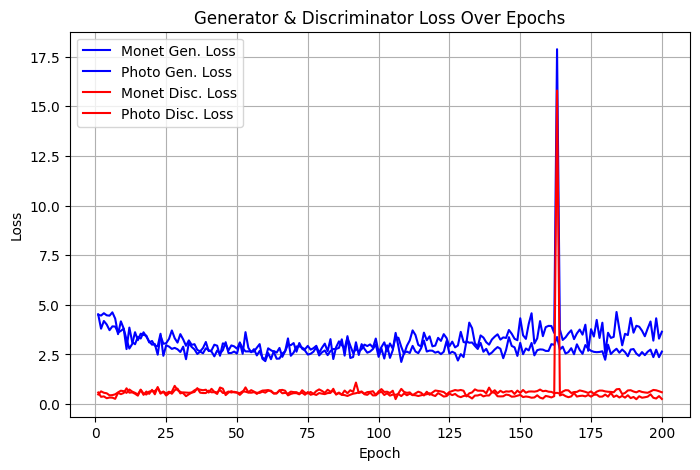

In [35]:
def plot_cycle_loss(history):

    monet_gen_loss = np.mean(history.history['monet_gen_loss'], axis=(1, 2, 3))
    photo_gen_loss = np.mean(history.history['photo_gen_loss'], axis=(1, 2, 3))
    monet_disc_loss = np.mean(history.history['monet_disc_loss'], axis=(1, 2, 3))
    photo_disc_loss = np.mean(history.history['photo_disc_loss'], axis=(1, 2, 3))

    epochs = range(1, len(monet_gen_loss) + 1)

    plt.figure(figsize=(8, 5))

    plt.plot(epochs, monet_gen_loss, label="Monet Gen. Loss", color='blue')
    plt.plot(epochs, photo_gen_loss, label="Photo Gen. Loss", color='blue')
    plt.plot(epochs, monet_disc_loss, label="Monet Disc. Loss", color='red')
    plt.plot(epochs, photo_disc_loss, label="Photo Disc. Loss", color='red')    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator & Discriminator Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cycle_loss(history)

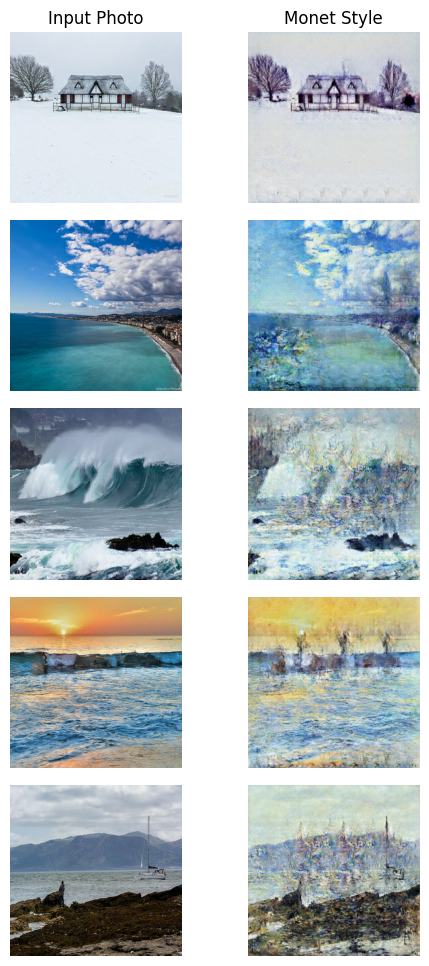

In [36]:
_, ax = plt.subplots(5, 2, figsize=(6, 12), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    if i == 0:
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet Style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

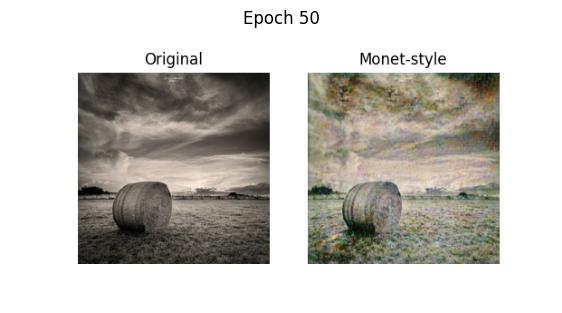

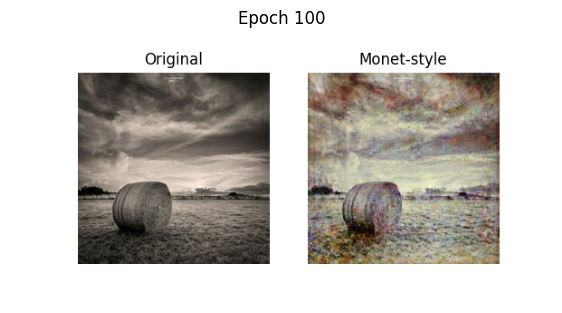

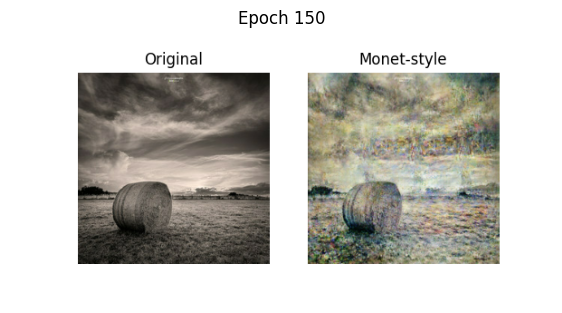

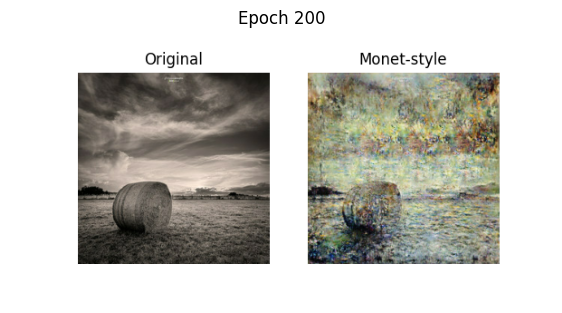

In [37]:
for epoch in range(50, EPOCHS + 1, 50):
    filename = f"cycle_e{epoch:04d}_{0}.png"  # Matches your saved image naming
    image_path = os.path.join('generated_images', filename)
    
    # Check if the file exists
    if os.path.exists(image_path):
        img = plt.imread(image_path)  # Load image from disk
        plt.figure(figsize=(7, 7))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Epoch {epoch}")
        plt.show()
    else:
        print(f"Skipping epoch {epoch}: {image_path} not found.")


In [38]:
import shutil
import PIL
img_path = "kaggle/working/images"
os.makedirs(img_path, exist_ok=True)
i = 1
#for img in photo_ds:
for batch in photo_ds:
    for j in range(batch.shape[0]):
        img = tf.expand_dims(batch[j], axis=0)
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save(os.path.join(img_path, str(i) + ".jpg"))
        i += 1
    #if i > 20: break

output_path = os.path.join(os.getcwd(), 'images')
shutil.make_archive(output_path, 'zip', img_path)
shutil.rmtree(img_path)

In [39]:
'''import os
import PIL.Image

output_path = 'kaggle/working'
img_path = os.path.join(output_path, "images")
os.makedirs(img_path, exist_ok=True)

i = 1
for img in photo_ds:
    # If photo_ds yields batched images, we take the first one.
    real_img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    generated = monet_generator(img, training=False)[0].numpy()
    generated = (generated * 127.5 + 127.5).astype(np.uint8)
    
    real_pil = PIL.Image.fromarray(real_img)
    gen_pil = PIL.Image.fromarray(generated)
    
    width, height = real_pil.size
    combined = PIL.Image.new("RGB", (width * 2, height))
    combined.paste(real_pil, (0, 0))
    combined.paste(gen_pil, (width, 0))
        combined.save(os.path.join(img_path, f"{i}.jpg"))
    i += 1'''

'import os\nimport PIL.Image\n\noutput_path = \'kaggle/working\'\nimg_path = os.path.join(output_path, "images")\nos.makedirs(img_path, exist_ok=True)\n\ni = 1\nfor img in photo_ds:\n    # If photo_ds yields batched images, we take the first one.\n    real_img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)\n\n    generated = monet_generator(img, training=False)[0].numpy()\n    generated = (generated * 127.5 + 127.5).astype(np.uint8)\n\n    real_pil = PIL.Image.fromarray(real_img)\n    gen_pil = PIL.Image.fromarray(generated)\n\n    width, height = real_pil.size\n    combined = PIL.Image.new("RGB", (width * 2, height))\n    combined.paste(real_pil, (0, 0))\n    combined.paste(gen_pil, (width, 0))\n        combined.save(os.path.join(img_path, f"{i}.jpg"))\n    i += 1'

# Conclusion

*DCGAN vs. CycleGAN*

While both our DCGAN and CycleGAN generated visually striking images, CycleGAN excelled at creating artwork that more closely resembles what a human would identify as Monet paintings. This advantage largely stems from its ability to work with concrete images—rather than synthesizing new representations from scratch, it focuses solely on translating an image’s style, ensuring greater fidelity to the essence of Monet’s work. In contrast, DCGAN attempts to generate scenes without direct reference images, which can lead to more abstract or inconsistent results, particularly as training progresses. CycleGAN's approach allows it to preserve recognizable structures while applying artistic textures, making its outputs more interpretable and aligned with real-world artistic styles.

*DCGAN ideas for improvement*

Although we failed in this notebook, a functional DCGAN would be even more impressive, as it could generate Monet-style images without relying on real image references. To improve our DCGAN’s ability to generate more realistic Monet images, several modifications could be explored. First, adjusting the latent space could help the model learn more expressive representations. Increasing the LATENT_DIM and experimenting with different distributions—such as Gaussian noise—may provide more variation in image generation. Additionally, modifying the generator architecture to include residual connections or different normalizations techniques could refine the style transfer process, preventing the network from collapsing into generic outputs. Another critical adjustment would be enhancing training stability, as mode collapse may be preventing the generator from utilizing latent vectors effectively. Reducing the learning rates and increasing epochs or implementing gradient penalty (such as in WGAN-GP) might also encourage more diverse outputs. Finally, we wanted to generate our model from scratch, but using a pretrained model to evaluate image realism could push the generator toward producing finer, more structured details aligned with Monet’s style. Along with further hyperparameter tuning these adjustments could lead to truly Monet-realistic images.

*CycleGAN Ideas for Improvement*

While CycleGAN performed better at preserving Monet's style, there are areas for improvement. One challenge is that some results show excessive distortion, particularly in details like water reflections or architecture. Perhaps this could be addressed by incorporating other losses or reducing transformations. One clear limitation is the small size of the Monet dataset. As such, another potential enhancement is introducing more diverse training examples. From an online search it seems that Monet pained as many as 2,500 pieces, so perhaps including more of these could help the generator’s ability to generalize Monet’s style effectively.

# References

I used the following tutorials to guide my model design.

DCGAN https://keras.io/examples/generative/dcgan_overriding_train_step/

Cycle GAN https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/
